**IMPORTS**

In [142]:
#pip install zipcodes
#!pip install -U pandasql
from folium.plugins import HeatMap
import folium
import zipcodes
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import pandasql
from datetime import datetime
import statsmodels.api as sm

**SPRINT 1: COLETA**

In [ ]:
# Coleta a tabela raíz do site, filtrando pelas datas desejadas
df_base = pd.DataFrame(pd.read_html("http://www.nuforc.org/webreports/ndxevent.html")[0])
for i, row in df_base.iterrows():
  if(row.Reports=='09/1997'):
    fim = i+1
  elif(row.Reports=='08/2017'):
    inicio = i

df_base = df_base[inicio:fim]

In [ ]:
# Concatenando as tabelas coletadas
df = pd.DataFrame()
for i, row in df_base.iterrows():
  data = row.Reports.split('/')
  df2 = pd.DataFrame(pd.read_html(f"http://www.nuforc.org/webreports/ndxe{data[1]}{data[0]}.html")[0])
  df = pd.concat([df, df2], ignore_index=True)

df.columns = ['data_hora' , 'cidade', 'estado', 'formato', 'duracao', 'resumo', 'data_postagem']
df.to_csv('OVNIS.csv')

**SPRINT 2: GRÁFICOS**

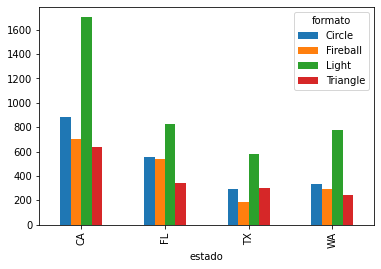

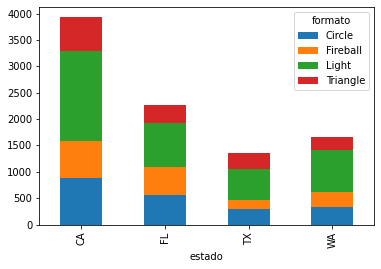

In [ ]:
# Lendo a base OVNIS
ovnis = pd.read_csv("OVNIS.csv")

query = """
SELECT estado, formato, COUNT(*) AS views FROM ovnis
WHERE estado IN('CA','FL','WA','TX') AND formato IN('Light','Circle','Triangle','Fireball')
GROUP BY estado, formato
"""
resultado = pd.DataFrame(pandasql.sqldf(query, locals()))

resultado.pivot("estado", "formato", "views").plot(kind='bar')
resultado.pivot("estado", "formato", "views").plot(kind='bar', stacked=True)

**SPRINT 2: MAPAS**

In [ ]:
# Gera as coordenadas das cidades dos Estados Unidos e salva em csv
csv_columns = ['cidade', 'estado', 'lat', 'long']
coords = []

for i, row in ovnis.iterrows():
  try:
    lat = zipcodes.filter_by(city=row.cidade, state=row.estado)[0]['lat']
    lng = zipcodes.filter_by(city=row.cidade, state=row.estado)[0]['long']
  except IndexError:
    continue

  coords.append({'cidade': row.cidade, 'estado': row.estado, 'lat': lat, 'long': lng})

pd.DataFrame(coords).to_csv('coords.csv')

In [ ]:
# Gera as coordenadas das cidades da Califórnia e salva em csv
coords_eua = pd.read_csv('coords.csv')
query = """
SELECT cidade, estado, lat, long FROM coords_eua
WHERE estado='CA'
"""
res = pandasql.sqldf(query, locals())
res = pd.DataFrame(res)
res.to_csv('coords_ca.csv')

In [ ]:
# Gera o mapa dos Estados Unidos e da Califórnia com suas respectivas ocorrências (1997-2017)
coords_eua = pd.read_csv('coords.csv')
coords_ca = pd.read_csv('coords_ca.csv')

lat_eua = coords_eua.lat.tolist()
lng_eua = coords_eua['long'].tolist()
lat_ca = coords_ca.lat.tolist()
lng_ca= coords_ca['long'].tolist()

mapa_eua = folium.Map(location=[37.8427887, -98.3807258], tiles='cartodbdark_matter', zoom_start=4.25)
mapa_ca = folium.Map(location=[37.2454668, -120.7021918], tiles='cartodbdark_matter', zoom_start=6)

HeatMap(list(zip(lat_eua, lng_eua)), radius=10, overlay=False).add_to(mapa_eua)
HeatMap(list(zip(lat_ca, lng_ca)), radius=10, overlay=False).add_to(mapa_ca)

In [ ]:
# Mostrar os mapas
mapa_eua
mapa_ca

**SPRINT 3: LIMPEZA**

In [ ]:
# Lendo o OVNIS.csv, apagando algumas colunas, e criando variáveis de controle
ovnis_df = pd.read_csv('OVNIS.csv')
ovnis_df = ovnis_df.drop(columns=['ID', 'duracao', 'resumo', 'data_postagem'])
estados = pd.read_excel('states.xlsx')['Abbreviation'].tolist()
formatos_relevantes = []
qr = "SELECT formato, COUNT(*) AS views FROM ovnis_df GROUP BY formato"

# Verificando quais são os formatos com mais de 1000 ocorrências
r = pd.DataFrame(pandasql.sqldf(qr, locals()))
for i, row in r.iterrows():
  if row.views>=1000:
    formatos_relevantes.append(row.formato)

''' 
Percorrendo o dataframe e apagando os registros que:

- Não estão dentre os estados dos Estados Unidos;
- Possuem registros Unknown
- Não pertencem ao grupo de formatos com mais de 1000 ocorrências
'''
for i, row in ovnis_df.iterrows():
  if row.estado not in estados:
    ovnis_df.drop(index=i, inplace=True)
  elif row.estado=='Unknown' or row.cidade=='Unknown' or row.formato=='Unknown':
    ovnis_df.drop(index=i, inplace=True)
  elif row.formato not in formatos_relevantes:
    ovnis_df.drop(index=i, inplace=True)

# Percorrendo o dataframe e apagando linhas com registros nulos
for i, row in ovnis_df.isna().iterrows():
  if row.estado==True or row.cidade==True or row.formato==True:
    ovnis_df.drop(index=i, inplace=True)

# Ajustando e salvando o arquivo
ovnis_df = ovnis_df.reset_index()
ovnis_df = ovnis_df.drop(columns=['index'])
ovnis_df.to_csv('df_OVNI_limpo.csv')

**SPRINT 3: ACRÉSCIMO DE VARIÁVEIS**

In [ ]:
# Lendo o df_OVNI_limpo.csv, criando listas e variáveis de controle
df_limpo = pd.read_csv('df_OVNI_limpo.csv')
df_limpo = df_limpo.drop(columns=['Unnamed: 0'])
dias = []
meses = []
weekdays = []
horas = []
datas = []
anos = []
DIAS = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-Feira', 'Sexta-feira', 'Sábado', 'Domingo']

# Percorrendo o dataframe e adicionando dados às listas criadas
for i, row in df_limpo.iterrows():
  try:
    horas.append(row.data_hora.split(' ')[1])
  except IndexError:
    horas.append(None)

  dt = datetime.strptime(row.data_hora.split(' ')[0], '%m/%d/%y')
  meses.append(dt.month)
  dias.append(dt.day)
  anos.append(dt.year)
  weekdays.append(DIAS[dt.weekday()])
  datas.append(row.data_hora.split(' ')[0])

# Atualizando o dataframe com novas colunas e salvando o arquivo
df_limpo = df_limpo.assign(data=datas, hora=horas, dia_semana=weekdays, dia=dias, mes=meses, ano=anos)
df_limpo.drop(columns=['data_hora'], inplace=True)
df_limpo.to_csv('df_OVNI_preparado.csv')

**SPRINT 4: PRIMEIRO GRÁFICO**

In [ ]:
# Lendo e ajustando o df_OVNI_preparado.csv
df_preparado = pd.read_csv('df_OVNI_preparado.csv')
df_preparado.drop(columns='Unnamed: 0', inplace=True)
df_preparado['data'] = pd.to_datetime(df_preparado['data'], format='%m/%d/%y')

# Consulta o dataframe para obter a formação desejada
ano = 2013
qr = f"""
SELECT data, mes, COUNT(*) AS views FROM df_preparado 
WHERE cidade='Phoenix' AND ano={ano} GROUP BY data"""
df_by_date = pd.DataFrame(pandasql.sqldf(qr, locals()))

In [ ]:
# Gera o figure do gráfico, as informações do eixo x e as seta o eixo y
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
eixo_mes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
eixo_views = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Atualiza as informações do eixo y de acordo com o que vem do dataframe
for i in range(0, len(df_by_date['mes'])):
  eixo_views[df_by_date['mes'][i]-1] += df_by_date['views'][i]

# Seta as informações do gráfico e exibe
ax.bar(eixo_mes, eixo_views)
ax.set_xlabel('meses')
ax.set_ylabel('avistamentos')
ax.set_title(f'Gráfico de avistamentos de OVNI em Phoenix ({ano})')
plt.show()

**SPRINT 4: SEGUNDO GRÁFICO**

In [ ]:
# Faz uma busca pelas views por data da cidade de Phoenix
qr = """
SELECT ano, COUNT(*) AS views FROM df_preparado 
WHERE cidade='Phoenix' GROUP BY ano"""
df_by_year = pd.DataFrame(pandasql.sqldf(qr, locals()))

# Gera os eixos x e y do gráfico
ypoints = df_by_year['views']
xpoints = list(map(str, df_by_year['ano']))

# Plota o gráfico (linhas)
plt.plot(xpoints, ypoints)
plt.show()

**SPRINT 4: SEPARAÇÃO DO DATAFRAME EM TREINAMENTO E TESTE**

In [ ]:
# Faz uma consulta pelas visualizacoes por data (novamente)
qr = f"""
SELECT data, COUNT(*) AS views FROM df_preparado 
WHERE cidade='Phoenix' GROUP BY data"""
d = pd.DataFrame(pandasql.sqldf(qr, locals()))

# Divide o dataframe resultante da consulta em treinamento (70%) e teste (30%)
treinamento, teste = d[0:198], d[198:]

In [156]:
modelo = SARIMAX(treinamento['views'], order=(1, 0, 0), trend='c')
res = modelo.fit()
print(f"A qualidade do modelo estimada pelo AIC é: {res.aic}\n")
print(f"Previsão: \n{res.forecast()}")

A qualidade do modelo estimada pelo AIC é: 282.35126963667506

Previsão: 
198    1.087409
dtype: float64
